# Data Analysis of P2P market as MAD problem
We evaluate the results of the simulation of a prosumer participating in a fully decentralized P2P market. This work is modelled as Multi-armed Bandit problem, a classic control problem that we can apply RL techniques.

This analysis starts by looking to the results presented in the Informs talk as ''Prosumer choice formulatedas Multi Armed Bandit problem - RL application''

In [1]:
# Import packages
import numpy as np
import pandas as pd
import pickle as pkl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

Start with upload the simulations done for the Informs talk that shows the first results with this work:

In [2]:
# Read pickle file
wok_dir = Path.cwd() / 'results/'
filename = 'sim_results_fixed_target_15_new_version.pkl'
path_file = wok_dir / filename
data = pkl.load(open(path_file, 'rb')) # Read file
# Plot parameters
plt_colmap = plt.get_cmap("tab10", 15)
sns.set_style("whitegrid")


In [10]:
## Define Plot functions

# Plot the mean reward per episode and RL_agent (You can have cumulative option as well)
def plot_reward_per_episode(df_score, y_feat, plt_label, plt_marker, size=(10,8), y_sum=False):
    # Get the plot parameters
    no_RL_agents = len(df_score) # Number of agents
    no_episodes = df_score[0].shape[0]
    plt.figure(figsize=size)
    x = np.arange(0, no_episodes) # Episode range
    for i in range(no_RL_agents):
        y = df_score[i][y_feat]
        y = np.cumsum(y) if y_sum else y # Cumulative plot
        plt.plot(x, y, label=plt_label[i], marker=plt_marker[i], linestyle='--')
        
# Plot the Q-action value per episode and RL_agent
def plot_Q_val_distribution(df_score, theta, plt_label, n_bins=20, size=(10,8)):
    from statsmodels.distributions.empirical_distribution import ECDF
    # Get the plot parameters
    no_RL_agents = len(df_score)
    no_episodes = df_score[0].shape[0]
    fig, axis = plt.subplots(1, 2, figsize=size, sharex=True)
    x = np.arange(0, no_episodes)
    for i in range(no_RL_agents):
        x = df_score[i][theta]
        axis[0].hist(x, density=True, bins=n_bins, label=plt_label[i])
        ecdf = ECDF(x)
        axis[1].plot(ecdf.x, ecdf.y, label=plt_label[i]) 
    return fig, axis

## Mean reward $\overline{R}_{Total}$ evolution per episode
Mean reward plot for all episodes with the following conditions:
 - The same Energy_target = 15 kWh for all episodes. 
 - Non-existing correlation, i.e. episodes are independent from each other
 - **Goal:** Evaluate the learning process of each policy (Random, Epsilon-greedy, Thompson-Sampler). If the *Epsilon-greedy* and *Thompson-Sampler* beat **constantly** the *Random policy*

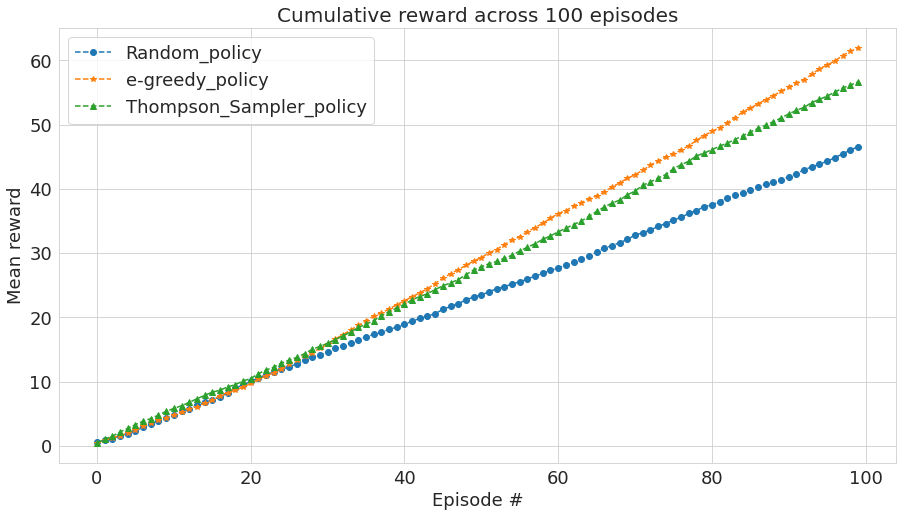

In [11]:
no_epi = data['simulation']['episodes']
label = data['agents']['id']
marker = ['o', '*', '^']
ax_label = ['Episode #', 'Mean reward']
ax_size = 18
plot_reward_per_episode(data['outcome'], 'mean_rd', label, marker, (15,8), True)
# Legend and labels for the plot
plt.legend(fontsize=ax_size)
plt.ylabel(ax_label[1], fontsize=ax_size)
plt.xticks(fontsize=ax_size)
plt.yticks(fontsize=ax_size)
plt.xlabel(ax_label[0], fontsize=ax_size)
plt.title(f'Cumulative reward across {no_epi} episodes', fontsize=20)
plt.show()

**Note:** Plotting the cumulative sum of the mean reward $R_{Total}$ instead; this results in the a **very** similar graph for the *Epsilon-greedy* and *Thompson-Sampler* policies.
***
## Mean regret $\overline{G}_{Total}$ per episode
Here we plot the estimated mean regret, if you remember the formulate. The regret is calculated as
\begin{equation}
    \overline{G}_{Total} = \frac{1}{N} \sum_n\left[ \max(\Q_n) - Q_n \right]
\end{equation} <br>
The true regret cannot be found because we are unaware of the **Probability Distribution**, Bernoulli $B(1, p_j)$ of each offer (arm $j$), instead we need to use the estimator $\hat{Q}^j_n$ as an approximation of $p_j$. Remember that $\hat{Q}^j_n$ is updated every step $n$.

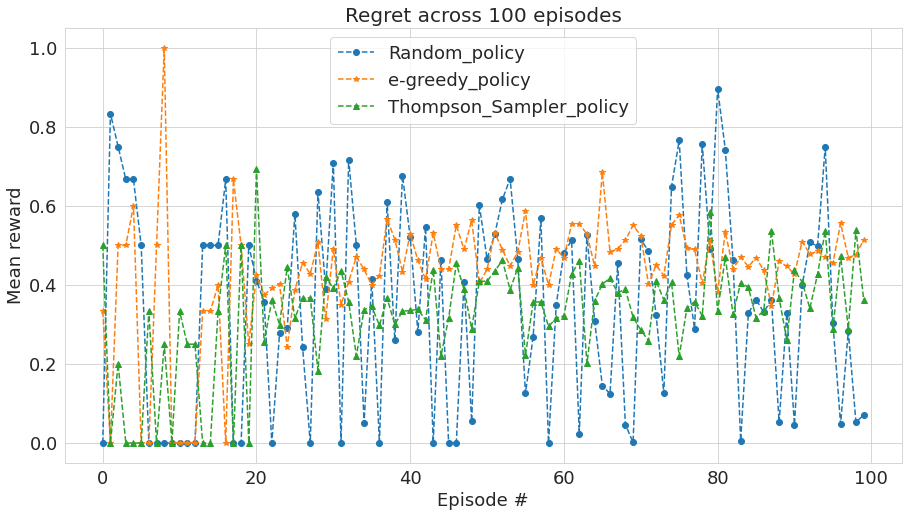

In [23]:
no_epi = data['simulation']['episodes']
label = data['agents']['id']
marker = ['o', '*', '^']
ax_label = ['Episode #', 'Mean reward']
ax_size = 18
plot_reward_per_episode(data['outcome'], 'mean_regret', label, marker, (15,8))
# Legend and labels for the plot
plt.legend(fontsize=ax_size)
plt.ylabel(ax_label[1], fontsize=ax_size)
plt.xticks(fontsize=ax_size)
plt.yticks(fontsize=ax_size)
plt.xlabel(ax_label[0], fontsize=ax_size)
plt.title(f'Regret across {no_epi} episodes', fontsize=20)
plt.show()

## Other analysis
We should look into the *a posteriori* probablity $\theta_n$ estimated at each step $n$. Since, the $\theta_n$ is a 2D array (steps x episodes). <br>
Per episode $e$ we have:
 - time-series of $\theta_n$
 - Estimated mean and standard deviation: $\overline{\theta_n}$ and $\sigma(\theta_n)$
 - Final theta $\hat{\theta}_n$: value of $\theta_n$ in the last step $n$ (when episode ends)

**Note:** We only compute $\theta_n$ for the *Random* and *Epsilon-greedy* policies: (*Thompson-Sampler* discards the $\theta_n$ estimation)

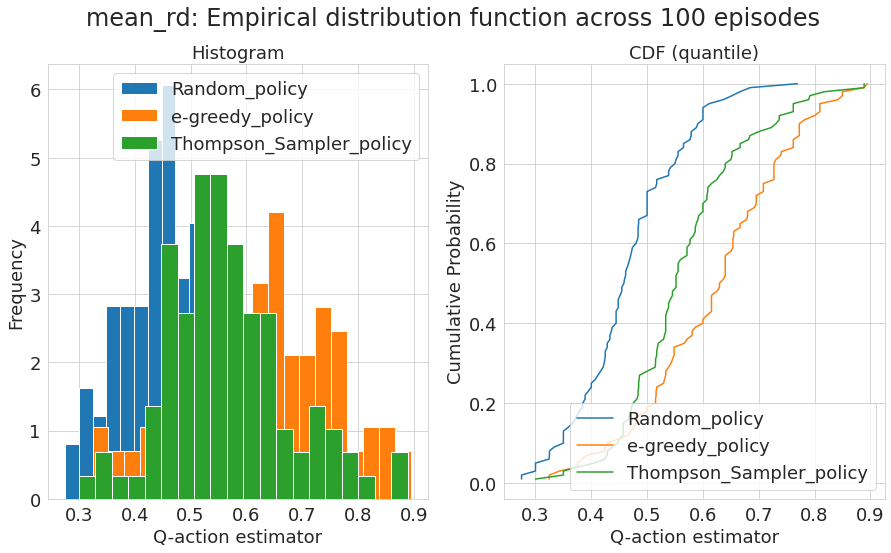

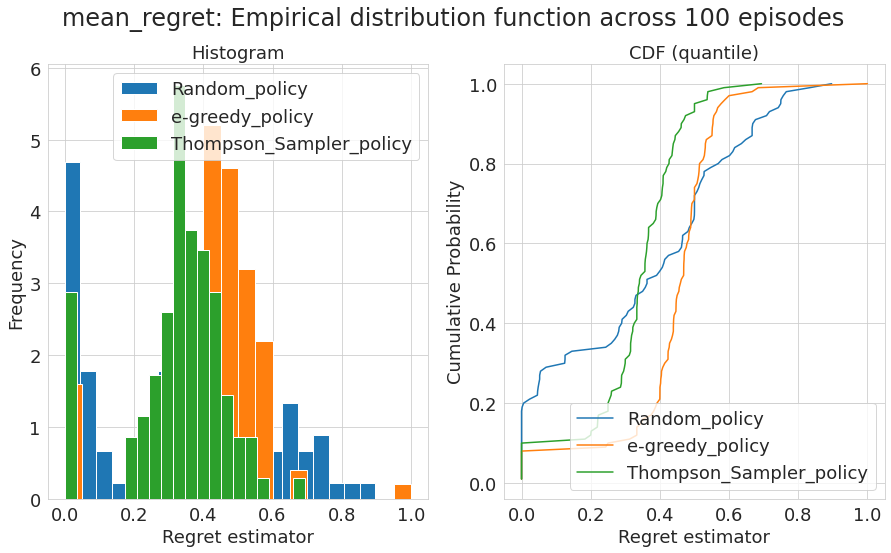

In [19]:
# Show the histogram and CDF of Q-action value, since it is probability estimator
theta_feat = ['mean_rd', 'mean_regret']
ax_label = ['Q-action estimator', 'Regret estimator', 'Frequency', 'Cumulative Probability']
subplot_title = ['Histogram', 'CDF (quantile)']
for theta in theta_feat:
    fg, ax = plot_Q_val_distribution(data['outcome'], theta, label, size=(15,8)) # Only plotting 'Random' and 'Epsilon-greedy'
    # Legend and labels for the plot
    [ax[i].legend(fontsize=ax_size) for i in range(len(ax))]
    x_id_label = 0 if theta == theta_feat[0] else 1
    [ax[i].set_xlabel(xlabel=ax_label[x_id_label], fontsize=ax_size) for i in range(len(ax))]
    [ax[i].set_ylabel(ylabel=ax_label[i+2], fontsize=ax_size) for i in range(len(ax))]
    [ax[i].tick_params(axis='x', labelsize=ax_size) for i in range(len(ax))]
    [ax[i].tick_params(axis='y', labelsize=ax_size) for i in range(len(ax))]
    # Set title
    [ax[i].set_title(subplot_title[i], fontsize=18) for i in range(len(ax))]
    fg.suptitle(f'{theta}: Empirical distribution function across {no_epi} episodes', fontsize=24)
    plt.show()
